In [70]:
import datetime as dt
import numpy as np
import xarray as xr

import scipy.ndimage as ndimage
import matplotlib.pyplot as plt
import pandas as pd
from dateutil.relativedelta import relativedelta
import cartopy.crs as ccrs
import scipy as sp
import subprocess
from joblib import Parallel, delayed
import dask.array as da
from scipy.stats import spearmanr
import seaborn as sns
import regionmask
import warnings
import cartopy.feature as cfeature
warnings.filterwarnings("ignore")
import matplotlib.colors as mcolors
import xskillscore as xs

In [71]:
#make a download directory
import os
if not os.path.exists('download'):
    os.makedirs('download')
if not os.path.exists('data'):
    os.makedirs('data')
if not os.path.exists('figures'):
    os.makedirs('figures')

In [72]:
download = False

1_ SST vs SPI Teleconnection (Lead 2.5) Oct Start OND Season

2_ Diff between ENSO and non-ENSO years Skill (Season wise) Correlation and RPSS and if possible for Reliability

3_ Trend in Model SP

## Load Data

In [73]:
cfsv2_url = "https://iridl.ldeo.columbia.edu/SOURCES/.Models/.NMME/.NCEP-CFSv2/.HINDCAST/.PENTAD_SAMPLES_FULL/.prec/Y/12/37/RANGE/X/32/60/RANGE/S/(days%20since%201960-01-01)/streamgridunitconvert/data.nc"
cfsv2_path = 'download/cfsv2_precip.nc'

gfdlspear_url = "https://iridl.ldeo.columbia.edu/SOURCES/.Models/.NMME/.GFDL-SPEAR/.HINDCAST/.MONTHLY/.prec/Y/12/37/RANGE/X/32/60/RANGE/S/(days%20since%201960-01-01)/streamgridunitconvert/data.nc"
gfdlspear_path = 'download/gfdlspear_precip.nc'

cansipsic4_url = "https://iridl.ldeo.columbia.edu/SOURCES/.Models/.NMME/.CanSIPS-IC4/.HINDCAST/.MONTHLY/.prec/Y/12/37/RANGE/X/32/60/RANGE/S/(days%20since%201960-01-01)/streamgridunitconvert/data.nc"
cansipsic4_path = 'download/cansipsic4_precip.nc'

cesm1_url = "https://iridl.ldeo.columbia.edu/SOURCES/.Models/.NMME/.COLA-RSMAS-CESM1/.MONTHLY/.prec/Y/12/37/RANGE/X/32/60/RANGE/S/(days%20since%201960-01-01)/streamgridunitconvert/data.nc"
cesm1_path = 'download/cesm1_precip.nc'

colaccsm4_url = "https://iridl.ldeo.columbia.edu/SOURCES/.Models/.NMME/.COLA-RSMAS-CCSM4/.MONTHLY/.prec/Y/12/37/RANGE/X/32/60/RANGE/S/(days%20since%201960-01-01)/streamgridunitconvert/data.nc"
colaccsm4_path = 'download/colaccsm4_precip.nc'

nasageos1_url = "https://iridl.ldeo.columbia.edu/SOURCES/.Models/.NMME/.NASA-GEOSS2S/.HINDCAST/.MONTHLY/.prec/Y/12/37/RANGE/X/32/60/RANGE/S/(days%20since%201960-01-01)/streamgridunitconvert/data.nc"
nasageos1_path = 'download/nasageos1_precip.nc'
nasageos2_url = "https://iridl.ldeo.columbia.edu/SOURCES/.Models/.NMME/.NASA-GEOSS2S/.FORECAST/.MONTHLY/.prec/Y/12/37/RANGE/X/32/60/RANGE/S/(days%20since%201960-01-01)/streamgridunitconvert/data.nc"
nasageos2_path = 'download/nasageos2_precip.nc'

if download:
    print(cfsv2_url)
    subprocess.call(['curl', '-b', 'cookies.txt', '-k', cfsv2_url, '-o', cfsv2_path])
    print(gfdlspear_url)
    subprocess.call(['curl', '-b', 'cookies.txt', '-k', gfdlspear_url, '-o', gfdlspear_path])
    print(cesm1_url)
    subprocess.call(['curl', '-b', 'cookies.txt', '-k', cesm1_url, '-o', cesm1_path])
    print(colaccsm4_url)
    subprocess.call(['curl', '-b', 'cookies.txt', '-k', colaccsm4_url, '-o', colaccsm4_path])
    print(nasageos1_url)
    subprocess.call(['curl', '-b', 'cookies.txt', '-k', nasageos1_url, '-o', nasageos1_path])
    print(nasageos2_url)
    subprocess.call(['curl', '-b', 'cookies.txt', '-k', nasageos2_url, '-o', nasageos2_path])
    #print(cansipsic4_url)
    #subprocess.call(['curl', '-b', 'cookies.txt', '-k', cansipsic4_url, '-o', cansipsic4_path])
    

In [74]:
cfsv2 = xr.open_dataset(cfsv2_path, decode_times=True)
gfdlspear = xr.open_dataset(gfdlspear_path, decode_times=True)
cesm1 = xr.open_dataset(cesm1_path, decode_times=True)
colaccsm4 = xr.open_dataset(colaccsm4_path, decode_times=True)
nasageos = xr.open_dataset(nasageos1_path, decode_times=True)
nasageos2 = xr.open_dataset(nasageos2_path, decode_times=True).isel(M=slice(0, 4))
#concatenate the two nasageos datasets
nasageos = xr.concat([nasageos, nasageos2], dim='S')
#cansipsic4 = xr.open_dataset(cansipsic4_path, decode_times=True)

nmme_dict =  {'cfsv2': cfsv2, 'gfdlspear': gfdlspear, 'cesm1': cesm1, 'colaccsm4': colaccsm4, 'nasageos': nasageos}


# First, concatenate all members from all NMME models
print("Concatenating all NMME members...")
all_nmme_data = []
all_member_names = []

for (nmme_name, nmme) in nmme_dict.items():
    print(f"Adding members from {nmme_name}")
    # Add model name to member names for identification
    members = nmme['M'].values
    for member in members:
        member_id = f"{nmme_name}_{member}"
        all_member_names.append(member_id)
        all_nmme_data.append(nmme.sel(M=member))

# Concatenate all members across models
print(f"Total members across all models: {len(all_member_names)}")
combined_nmme = xr.concat(all_nmme_data, dim='M')
combined_nmme = combined_nmme.assign_coords(M=all_member_names)

total_members = len(all_member_names)

Concatenating all NMME members...
Adding members from cfsv2
Adding members from gfdlspear
Adding members from cesm1
Adding members from colaccsm4
Adding members from nasageos
Total members across all models: 67


In [75]:
cmap_url = "https://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NCEP/.CPC/.Merged_Analysis/.monthly/.latest/.ver1/.prcp_est/X/-180/1/179/GRID/Y/-90/1/90/GRID/Y/12/37/RANGE/X/32/60/RANGE/T/(days%20since%201960-01-01)/streamgridunitconvert/data.nc"
cmap_path = 'download/cmap_precip.nc'

print(cmap_url)
subprocess.call(['curl', '-b', 'cookies.txt', '-k', cmap_url, '-o', cmap_path])

cmap = xr.open_dataset(cmap_path, decode_times=True)
#change datetime to 01-MM-YYYY
new_dates = pd.to_datetime(cmap['T'].values, format="%d-%m-%Y").strftime("01-%m-%Y")
cmap['T'] = pd.to_datetime(new_dates, format="%d-%m-%Y")
obs = cmap['prcp_est']

obs_3m = obs + obs.shift(T=1) + obs.shift(T=2)
obs_3m = obs_3m.dropna('T')


https://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NCEP/.CPC/.Merged_Analysis/.monthly/.latest/.ver1/.prcp_est/X/-180/1/179/GRID/Y/-90/1/90/GRID/Y/12/37/RANGE/X/32/60/RANGE/T/(days%20since%201960-01-01)/streamgridunitconvert/data.nc


In [76]:
spi_obs = xr.load_dataset('../data/spi3_cmap_1x1.nc')
#rename variable __xarray_dataarray_variable__ to spi
spi_obs = spi_obs.rename({'__xarray_dataarray_variable__':'spi'}).spi.sortby('T')

In [77]:
# Load data and parse Date column
nino34 = pd.read_csv(
    "data/nino34.csv",
    parse_dates=["Date"]
)

# Set Date as index
nino34 = nino34.set_index("Date")

# Select 1950–2020
nino34_ = nino34.loc["1950-01-01":"2025-12-31", "NINO3.4"]

# 3-month rolling mean
nino_3m = pd.DataFrame(nino34_.rolling(window=3, center=False).mean(), columns=["NINO3.4"])
nino_3m["ENSO"] = (
    (nino_3m["NINO3.4"] >= 0.5) |
    (nino_3m["NINO3.4"] <= -0.5)
).astype(int)


# --------------------------------------------------
# ENSO dummy → xarray-ready (monthly, datetime index)
# --------------------------------------------------
enso_dummy = nino_3m["ENSO"].copy()
enso_dummy.index = pd.to_datetime(enso_dummy.index)


In [78]:
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
seasons = ['NDJ', 'DJF', 'JFM', 'FMA', 'MAM', 'AMJ', 'MJJ', 'JJA', 'JAS', 'ASO', 'SON', 'OND']
selected_seasons = ['OND', 'NDJ', 'DJF', 'JFM', 'FMA', 'MAM']
seasons_to_label = {"OND":"a)", "NDJ":"b)", "DJF":"c)", "JFM":"d)", "FMA":"e)", "MAM":"f)"}



In [79]:
mask = regionmask.defined_regions.natural_earth_v5_0_0.land_110.mask( spi_obs['X'], spi_obs['Y'])

# Deterministic Skill

In [80]:

lead_time = 2  # 2.5-month lead

for nmme in spi_hindcast_dict.keys():

    spi_hindcast = spi_hindcast_dict[nmme]
    precip_fcast = precip_fcast_dict[nmme]

    season_corr_precip = {s: {"ENSO": [], "Neutral": []} for s in selected_seasons}
    season_corr_spi    = {s: {"ENSO": [], "Neutral": []} for s in selected_seasons}

    for s_month in range(1, 13):

        t_month = (s_month + lead_time) % 12 or 12
        target_season = seasons[t_month - 1]
        if target_season not in selected_seasons:
            continue

        # ---- forecasts ----
        P_fcst_mon = (
            precip_fcast
            .sel(S=precip_fcast["S.month"] == s_month)
            .isel(L=lead_time)
            .drop_vars("L")
        )

        spi_fcst_mon = (
            spi_hindcast
            .sel(S=spi_hindcast["S.month"] == s_month)
            .isel(L=lead_time)
            .drop_vars("L")
        )

        # shift S → T
        T_vals = [s + pd.DateOffset(months=lead_time) for s in P_fcst_mon["S"].values]
        P_fcst_mon = P_fcst_mon.assign_coords(S=T_vals).rename({"S": "T"})
        spi_fcst_mon = spi_fcst_mon.assign_coords(S=T_vals).rename({"S": "T"})

        # ---- observations ----
        P_obs_mon = obs_3m.sel(T=obs_3m["T.month"] == t_month).sel(T=P_fcst_mon["T"])
        spi_obs_mon = spi_obs.sel(T=spi_obs["T.month"] == t_month).sel(T=spi_fcst_mon["T"])

        # ---- ENSO mask as xarray DataArray ----
        enso_state = xr.DataArray(
            enso_dummy.reindex(P_fcst_mon["T"].values).values,
            coords={"T": P_fcst_mon["T"].values},
            dims="T"
        )

        enso_mask = enso_state == 1
        neutral_mask = enso_state == 0

        # ---- ENSO-active ----
        if enso_mask.sum() > 3:
            season_corr_precip[target_season]["ENSO"].extend(
                xr.corr(
                    P_fcst_mon.where(enso_mask, drop=True),
                    P_obs_mon.where(enso_mask, drop=True),
                    dim="T"
                ).values.flatten()
            )

            season_corr_spi[target_season]["ENSO"].extend(
                xr.corr(
                    spi_fcst_mon.where(enso_mask, drop=True),
                    spi_obs_mon.where(enso_mask, drop=True),
                    dim="T"
                ).values.flatten()
            )

        # ---- Neutral ----
        if neutral_mask.sum() > 3:
            season_corr_precip[target_season]["Neutral"].extend(
                xr.corr(
                    P_fcst_mon.where(neutral_mask, drop=True),
                    P_obs_mon.where(neutral_mask, drop=True),
                    dim="T"
                ).values.flatten()
            )

            season_corr_spi[target_season]["Neutral"].extend(
                xr.corr(
                    spi_fcst_mon.where(neutral_mask, drop=True),
                    spi_obs_mon.where(neutral_mask, drop=True),
                    dim="T"
                ).values.flatten()
            )

    # --------------------------------------------------
    # FINAL PLOT: one figure, all seasons, ENSO vs Neutral
    # --------------------------------------------------
    for var, corr_dict in [("precip", season_corr_precip), ("spi", season_corr_spi)]:

        df_plot = pd.concat(
            [
                pd.DataFrame({
                    "Season": season,
                    "ENSO_state": state,
                    "Correlation": corr_dict[season][state]
                })
                for season in selected_seasons
                for state in ["ENSO", "Neutral"]
            ],
            ignore_index=True
        )

        plt.figure(figsize=(8, 6))

        sns.boxplot(
            data=df_plot,
            x="Season",
            y="Correlation",
            hue="ENSO_state",
            showfliers=False,
            palette={"Neutral": "lightblue", "ENSO": "cornflowerblue"},  # blue / red
            linewidth=1.6
        )

        # Zero line
        plt.axhline(0, color="black", linestyle="--", linewidth=1.2)

        # Title & labels
        plt.title(
            f"{nmme.upper()} – ENSO-conditioned skill",
            fontsize=18,
            fontweight="bold",
            pad=10
        )

        plt.ylabel("Spatial Correlation", fontsize=14, fontweight="bold")
        plt.xlabel("")

        # Tick styling
        plt.xticks(fontsize=13, fontweight="bold")
        plt.yticks(fontsize=13)

        # Legend styling
        plt.legend(
            title="",
            fontsize=14,
            frameon=False,
            loc="lower right"
        )

        # Axis spine styling
        ax = plt.gca()
        for spine in ["top", "right"]:
            ax.spines[spine].set_visible(False)

        for spine in ["left", "bottom"]:
            ax.spines[spine].set_linewidth(1.4)

        plt.tight_layout()


        plt.savefig(
            f"figures/{var}_{nmme}_lead2p5_ENSO_seasons.pdf",
            dpi=300
        )
        plt.close()


# RPSS

In [81]:
# compute month-specific quantiles (per gridpoint)
q33 = spi_obs.sel(T=slice('1991-01-01', '2020-12-31')).groupby('T.month').quantile(0.33, dim='T')
q67 = spi_obs.sel(T=slice('1991-01-01', '2020-12-31')).groupby('T.month').quantile(0.67, dim='T')

# classify directly with groupby.map
def classify_month(da, q33=q33, q67=q67):
    m = int(da['T.month'][0])  # current month
    low = q33.sel(month=m)
    high = q67.sel(month=m)

    out = xr.full_like(da, np.nan, dtype=int)
    out = xr.where(da <= low, 0, out)
    out = xr.where((da > low) & (da < high), 1, out)
    out = xr.where(da >= high, 2, out)
    return out

spi_cat = spi_obs.groupby('T.month').map(classify_month)

# keep NaN where original was NaN
spi_cat = spi_cat.where(~np.isnan(spi_obs))

In [82]:
from scipy.stats import pearson3, norm
def compute_spi_pearson3(da, dim='S'):
    """
    Compute SPI (Standardized Precipitation Index) using Pearson Type III distribution
    along the specified time dimension.
    """
    def _spi_1d(x):
        x = np.asarray(x, dtype=float)
        mask = np.isfinite(x)

        if mask.sum() < 3 or np.all(x[mask] <= 0):
            return np.full_like(x, np.nan, dtype=float)

        try:
            skew, loc, scale = pearson3.fit(x[mask])
            cdf = pearson3.cdf(x[mask], skew, loc=loc, scale=scale)
            spi_vals = norm.ppf(cdf)
            out = np.full_like(x, np.nan, dtype=float)
            out[mask] = spi_vals
            return out
        except Exception:
            return np.full_like(x, np.nan, dtype=float)

    # Apply along time dimension
    spi = xr.apply_ufunc(
        _spi_1d,
        da,
        input_core_dims=[[dim]],
        output_core_dims=[[dim]],   # preserve time dim
        vectorize=True,
        dask="parallelized",
        output_dtypes=[float],
    )

    return spi

In [83]:
def compute_rpss_subset_enso(
    obs,
    fcst,
    enso_dummy,
    seasons,
    selected_seasons,
):
    n_cat = 3
    ref_probs = np.ones(n_cat) / n_cat
    TARGET_LEAD_INDEX = 2  # 2.5 months

    # container: season → ENSO state → values
    season_rpss = {
        s: {"ENSO": [], "Neutral": []}
        for s in selected_seasons
    }

    enso_dummy = enso_dummy.copy()
    enso_dummy.index = pd.to_datetime(enso_dummy.index)

    for s_month in range(1, 13):
        print(f"Processing start month: {months[s_month-1]}")


        lead_time = TARGET_LEAD_INDEX
        t_month = (s_month + lead_time) % 12 or 12
        target_season = seasons[t_month - 1]

        if target_season not in selected_seasons:
            continue

        # --------------------------------------------------
        # Forecast aggregation (UNCHANGED)
        # --------------------------------------------------
        fcst_sel = (
            fcst.sel(S=fcst["S.month"] == s_month).isel(L=lead_time)
            + fcst.sel(S=fcst["S.month"] == s_month).isel(L=lead_time - 1)
            + fcst.sel(S=fcst["S.month"] == s_month).isel(L=lead_time - 2)
        )

        spi_fcst = compute_spi_pearson3(fcst_sel, dim="S")

        # S → T
        S_vals = fcst_sel["S"].values
        T_vals = [pd.Timestamp(s) + pd.DateOffset(months=lead_time) for s in S_vals]
        spi_fcst = spi_fcst.assign_coords(S=T_vals).rename({"S": "T"})

        # --------------------------------------------------
        # Terciles (GLOBAL)
        # --------------------------------------------------
        # --- Compute tercile thresholds from SPI forecasts ---
        q33 = spi_fcst.quantile(0.33, dim=["M", "T"], skipna=True).drop_vars("quantile", errors="ignore")
        q67 = spi_fcst.quantile(0.67, dim=["M", "T"], skipna=True).drop_vars("quantile", errors="ignore")
        q33_b = q33.broadcast_like(spi_fcst)
        q67_b = q67.broadcast_like(spi_fcst)

        # Boolean masks
        mask_below = spi_fcst < q33_b
        mask_near  = (spi_fcst >= q33_b) & (spi_fcst <= q67_b)
        mask_above = spi_fcst > q67_b

        # Ensemble probabilities
        below = mask_below.mean(dim="M", skipna=True)
        near  = mask_near.mean(dim="M", skipna=True)
        above = mask_above.mean(dim="M", skipna=True)

        prob = xr.concat([below, near, above], dim="category").assign_coords(category=[0, 1, 2])

        # Matching obs
        obs_month = obs.sel(T=prob['T'])
        prob = prob.where(obs_month.notnull(), drop=False).transpose('T', 'Y', 'X', 'category').sortby('T')
        prob = prob.where(mask==0)

        # Reference probabilities
        ref_probs_da = xr.DataArray(ref_probs, dims=["category"])
        ref_probs_broadcast = ref_probs_da.broadcast_like(prob)

        # One-hot encode obs
        ohe_obs = xr.concat([
            (obs_month == 0).assign_coords(category=0),
            (obs_month == 1).assign_coords(category=1),
            (obs_month == 2).assign_coords(category=2),
        ], dim='category').where(obs_month.notnull()).transpose('T', 'Y', 'X', 'category').sortby('T')


        # --------------------------------------------------
        # ENSO mask (on T)
        # --------------------------------------------------
        enso_state = xr.DataArray(
            enso_dummy.reindex(prob["T"].values).values,
            coords={"T": prob["T"].values},
            dims="T",
        )

        enso_mask = enso_state == 1
        neutral_mask = enso_state == 0

        #cmpute RPSS for ENSO-active
        if enso_mask.sum() > 3:
            prob_enso = prob.where(enso_mask, drop=True)
            ohe_obs_enso = ohe_obs.where(enso_mask, drop=True)
            ref_probs_enso = ref_probs_broadcast.where(enso_mask, drop=True)

            rps_vals = xs.rps(ohe_obs_enso, prob_enso, dim="T", category_edges=None, input_distributions="p")
            ref_rps_vals = xs.rps(ohe_obs_enso, ref_probs_enso, dim="T", category_edges=None, input_distributions="p")
            rpss = 1 - (rps_vals / ref_rps_vals)

            season_rpss[target_season]["ENSO"].extend(rpss.values.flatten())
        # ---- Neutral ----
        if neutral_mask.sum() > 3:
            prob_neutral = prob.where(neutral_mask, drop=True)
            ohe_obs_neutral = ohe_obs.where(neutral_mask, drop=True)
            ref_probs_neutral = ref_probs_broadcast.where(neutral_mask, drop=True)

            rps_vals = xs.rps(ohe_obs_neutral, prob_neutral, dim="T", category_edges=None, input_distributions="p")
            ref_rps_vals = xs.rps(ohe_obs_neutral, ref_probs_neutral, dim="T", category_edges=None, input_distributions="p")
            rpss = 1 - (rps_vals / ref_rps_vals)

            season_rpss[target_season]["Neutral"].extend(rpss.values.flatten())



    return season_rpss

In [84]:
season_rpss = compute_rpss_subset_enso(
    obs=spi_cat,
    fcst=combined_nmme.prec.sel(
        S=slice('1991-01-01', '2020-12-31'),
        L=slice(0.5, 2.5)), 
    enso_dummy=enso_dummy,
    seasons=seasons,
    selected_seasons=selected_seasons)



Processing start month: Jan
Processing start month: Feb
Processing start month: Mar
Processing start month: Apr
Processing start month: May
Processing start month: Jun
Processing start month: Jul
Processing start month: Aug
Processing start month: Sep
Processing start month: Oct
Processing start month: Nov
Processing start month: Dec


In [92]:
import pickle

with open("data/season_rpss_enso_neutral.pkl", "wb") as f:
    pickle.dump(season_rpss, f)

In [93]:
with open("data/season_rpss_enso_neutral.pkl", "rb") as f:
    season_rpss = pickle.load(f)

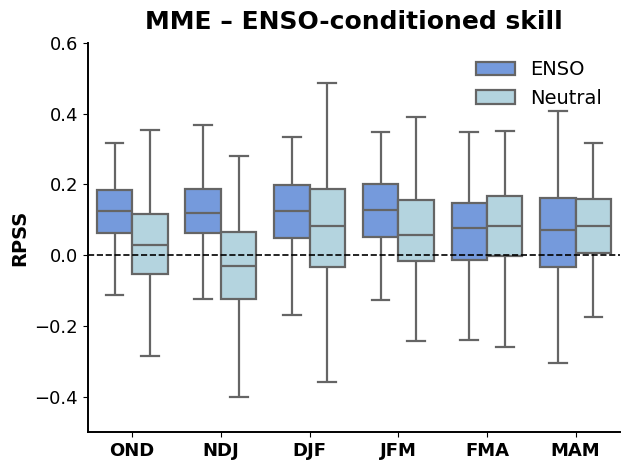

In [94]:
df_plot = pd.concat(
    [
        pd.DataFrame({
            "Season": season,
            "ENSO_state": state,
            "RPSS": season_rpss[season][state],
        })
        for season in selected_seasons
        for state in ["ENSO", "Neutral"]
    ],
    ignore_index=True,
)

sns.boxplot(
    data=df_plot,
    x="Season",
    y="RPSS",
    hue="ENSO_state",
    showfliers=False,
    palette={"Neutral": "lightblue", "ENSO": "cornflowerblue"},  # blue / red
    linewidth=1.6
)

# Zero line
plt.axhline(0, color="black", linestyle="--", linewidth=1.2)

# Title & labels
plt.title(
    f"{nmme.upper()} – ENSO-conditioned skill",
    fontsize=18,
    fontweight="bold",
    pad=10
)

plt.ylabel("RPSS", fontsize=14, fontweight="bold")
plt.xlabel("")
plt.ylim(-0.5, 0.6)

# Tick styling
plt.xticks(fontsize=13, fontweight="bold")
plt.yticks(fontsize=13)

# Legend styling
plt.legend(
    title="",
    fontsize=14,
    frameon=False,
    loc="upper right"
)

# Axis spine styling
ax = plt.gca()
for spine in ["top", "right"]:
    ax.spines[spine].set_visible(False)

for spine in ["left", "bottom"]:
    ax.spines[spine].set_linewidth(1.4)

plt.tight_layout()


plt.savefig(
    f"figures/spi_RPSS_lead2p5_ENSO_seasons.pdf",
    dpi=300
)
